In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import ImageChops, Image

from keras.datasets import cifar10
from keras.models import load_model
from keras.utils import to_categorical
from keras import backend as K

from cleverhans.attacks import FastGradientMethod, LBFGS
from cleverhans.utils_keras import KerasModelWrapper

import sys
sys.path.append('../Final_notebook/')
import proj_utils as utils

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

y_test_tmp = np.squeeze(y_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [3]:
model = load_model('../Saved_models/good_models/cifar10/cifar10_vgg_like_175.h5')

In [4]:
K.set_learning_phase(0)
ch_model = KerasModelWrapper(model)
fgsm = FastGradientMethod(ch_model, sess=K.get_session())
fgsm_params = {'eps': 3.0/255,
               'clip_min': 0.0,
               'clip_max': 1.0}
#fgsm_params = {'eps': 0.01}

In [5]:
i = 421
img = x_test[i]
adv = fgsm.generate_np(np.expand_dims(img, axis=0), **fgsm_params)[0]

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [6]:
model.predict(np.expand_dims(img, axis=0))

array([[1.9939040e-07, 7.4184286e-10, 1.3745290e-05, 1.1238615e-03,
        1.0912589e-04, 9.9855655e-01, 4.7063233e-05, 1.4931468e-04,
        7.7231057e-09, 7.2748399e-08]], dtype=float32)

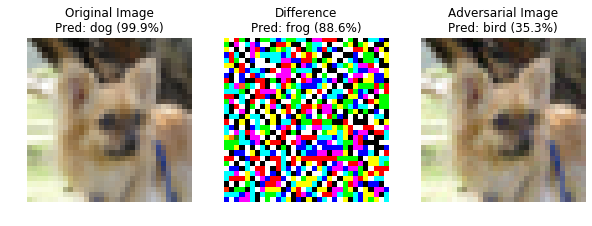

In [7]:
utils.plot_pair(img, adv, model=model)

In [8]:
og_diff = adv - img
diff = adv - img
diff = diff + abs(diff.min())
diff = diff / diff.max()

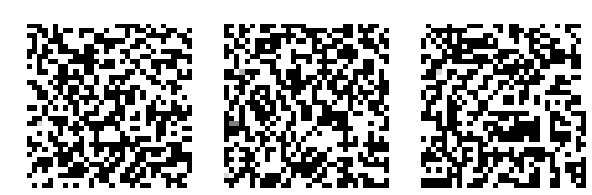

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(10, 9))
for i in range(3):
    axs[i].matshow(diff[:, :, i], cmap='gray')
    axs[i].axis('off')

In [10]:
gradient = utils.gradient_loss_wrt_input(np.expand_dims(img, axis=0), np.expand_dims(y_test[421], axis=0), model)
gradient = np.squeeze(gradient)

In [11]:
eps = 3.0/255
grad_sign = np.sign(gradient)
diff1 = eps * grad_sign
og_diff1 = eps * grad_sign

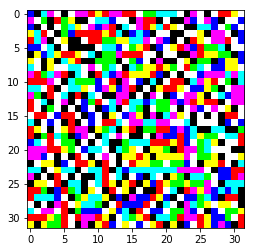

In [12]:
diff1 = diff1 + abs(diff1.min())
diff1 = diff1 / diff1.max()  
plt.imshow(diff1)

In [13]:
#MAE processed noise
print(np.sum(np.abs(diff - diff1)) / (32*32*3))

# MAE original noise
print(np.sum(np.abs(og_diff - og_diff1)) / (32*32*3))

0.0005974387403823077
1.4055474514630808e-05


In [14]:
model.predict(np.expand_dims(diff1, axis=0))

array([[1.70496924e-06, 1.35195747e-04, 1.04175095e-04, 2.69425050e-06,
        4.11357823e-11, 9.96351801e-09, 9.97923076e-01, 1.35112979e-08,
        1.10433807e-09, 1.83315657e-03]], dtype=float32)

In [22]:
# RMSE?
print(32*32*3)
np.linalg.norm((adv - img).flatten()) #/ np.sqrt(32*32*3)

3072


0.011764735567803497

In [16]:
np.linalg.norm((img - adv).flatten(), 0)

3070.0

https://stackoverflow.com/questions/189943/how-can-i-quantify-difference-between-two-images

## Imagechops

In [53]:
img = (img * 255).astype('uint8')
adv = (adv * 255).astype('uint8')

img = Image.fromarray(img)
adv = Image.fromarray(adv)

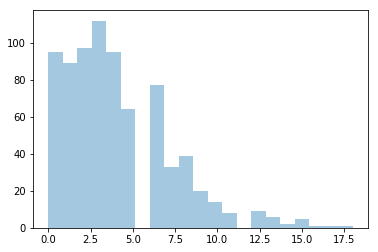

In [54]:
sns.distplot(img.histogram(), kde=False)

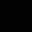